# Efficient COCO Dataset Generator

This notebook was Inspired by [this](https://www.kaggle.com/slawekbiel/positive-score-with-detectron-1-3-input-data?scriptVersionId=77658860) great notebook. I made a few improvements in the `rle2mask` code to make it more efficient and used the functions provided in `pycocotools` to generate the json file. This results in massive reduction of compute time and dataset size.

What seemed at first to be a trivial task was a bit difficult as the RLE encoding used by COCO is very different from the encoding used in this comp.  

The comp encoding is rowise and every `odd` index represent the absolute begining of the mask. In the other hand, coco format expects it to be encoded by columns and the `odd` indexes are relative to the last end of the mask.

I couldn't find a trivial way to convert from those two formats without decoding the rle to mask, so the workflow is as folows:

1. Decode rle (competition) to binary mask
1. Encode the binary mask to rle (coco) using `pycocotools`
1. Save to `.json`

In [1]:
# !pip install -Uqqq pycocotools
# !pip install 'git+https://github.com/facebookresearch/detectron2.git'

In [2]:
%config Completer.use_jedi = False # use autocompletion

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import detectron2
from pathlib import Path
import random, cv2, os
import matplotlib.pyplot as plt
import numpy as np
import pycocotools.mask as mask_util
# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.utils.logger import setup_logger
from detectron2.evaluation.evaluator import DatasetEvaluator
from detectron2.engine import BestCheckpointer
from detectron2.checkpoint import DetectionCheckpointer
# import PyCOCO tools
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image

setup_logger()

<Logger detectron2 (DEBUG)>

## Loading the train dataframe

In [3]:
# df = pd.read_csv('sartorius-cell-instance-segmentation/train.csv')
# df.head()

## Function that decodes rle (for this comp) to a binary mask

In [4]:
# ## Based on: https://www.kaggle.com/eigrad/convert-rle-to-bounding-box-x0-y0-x1-y1
# def rle2mask(rle, img_w, img_h):
    
#     ## transforming the string into an array of shape (2, N)
#     array = np.fromiter(rle.split(), dtype = np.uint)
#     array = array.reshape((-1,2)).T
#     array[0] = array[0] - 1
    
#     ## decompressing the rle encoding (ie, turning [3, 1, 10, 2] into [3, 4, 10, 11, 12])
#     # for faster mask construction
#     starts, lenghts = array
#     mask_decompressed = np.concatenate([np.arange(s, s + l, dtype = np.uint) for s, l in zip(starts, lenghts)])

#     ## Building the binary mask
#     msk_img = np.zeros(img_w * img_h, dtype = np.uint8)
#     msk_img[mask_decompressed] = 1
#     msk_img = msk_img.reshape((img_h, img_w))
#     msk_img = np.asfortranarray(msk_img) ## This is important so pycocotools can handle this object
    
#     return msk_img

## Minor Sanity Check

In [5]:
# rle = df.loc[0, 'annotation']
# print(rle)
# plt.imshow(rle2mask(rle, 704, 520));

## Function that builds the .json file

In [6]:
# from tqdm.notebook import tqdm
# from pycocotools import mask as maskUtils
# from joblib import Parallel, delayed

# def annotate(idx, row, cat_ids):
#         mask = rle2mask(row['annotation'], row['width'], row['height']) # Binary mask
#         c_rle = maskUtils.encode(mask) # Encoding it back to rle (coco format)
#         c_rle['counts'] = c_rle['counts'].decode('utf-8') # converting from binary to utf-8
#         area = maskUtils.area(c_rle).item() # calculating the area
#         bbox = maskUtils.toBbox(c_rle).astype(int).tolist() # calculating the bboxes
#         annotation = {
#             'segmentation': c_rle,
#             'bbox': bbox,
#             'area': area,
#             'image_id':row['id'], 
#             'category_id':cat_ids[row['cell_type']], 
#             'iscrowd':0, 
#             'id':idx
#         }
#         return annotation
    
# def coco_structure(df, workers = 4):
#     ## Building the header
#     cat_ids = {name:id+1 for id, name in enumerate(df.cell_type.unique())}    
#     cats =[{'name':name, 'id':id} for name,id in cat_ids.items()]
#     images = [{'id':id, 'width':row.width, 'height':row.height, 'file_name':f'train/{id}.png'} for id,row in df.groupby('id').agg('first').iterrows()]
    
#     ## Building the annotations
#     annotations = Parallel(n_jobs=workers)(delayed(annotate)(idx, row, cat_ids) for idx, row in tqdm(df.iterrows(), total = len(df)))
        
#     return {'categories':cats, 'images':images, 'annotations':annotations}

## Split df according to class and prepare train and val json for each class.

In [7]:
# import json,itertools

# np.random.seed(42)

# def split_df(df, thresh):
#     all_ids = df.id.unique()
#     np.random.shuffle(all_ids)
#     thresh = int(all_ids.shape[0]*0.8) + 1

#     train_df = df[df.id.isin(all_ids[:thresh])]
#     val_df = df[df.id.isin(all_ids[thresh:])]

#     train = coco_structure(train_df)
#     val = coco_structure(val_df)
    
#     return train, val

# df_c0 = df[df.cell_type == 'shsy5y']
# df_c1 = df[df.cell_type == 'astro']
# df_c2 = df[df.cell_type == 'cort']

# train, val = split_df(df, 0.8)
# train_c0, val_c0 = split_df(df_c0, 0.8)
# train_c1, val_c1 = split_df(df_c1, 0.8)
# train_c2, val_c2 = split_df(df_c2, 0.8)

In [8]:
# with open('sartorius-cell-instance-segmentation-coco/annotations_train.json', 'w+', encoding='utf-8') as f:
#     json.dump(train, f, ensure_ascii=True, indent=4)
# with open('sartorius-cell-instance-segmentation-coco/annotations_val.json', 'w+', encoding='utf-8') as f:
#     json.dump(val, f, ensure_ascii=True, indent=4)
# with open('sartorius-cell-instance-segmentation-coco/annotations_train_c0.json', 'w+', encoding='utf-8') as f:
#     json.dump(train_c0, f, ensure_ascii=True, indent=4)
# with open('sartorius-cell-instance-segmentation-coco/annotations_val_c0.json', 'w+', encoding='utf-8') as f:
#     json.dump(val_c0, f, ensure_ascii=True, indent=4)
# with open('sartorius-cell-instance-segmentation-coco/annotations_train_c1.json', 'w+', encoding='utf-8') as f:
#     json.dump(train_c1, f, ensure_ascii=True, indent=4)
# with open('sartorius-cell-instance-segmentation-coco/annotations_val_c1.json', 'w+', encoding='utf-8') as f:
#     json.dump(val_c1, f, ensure_ascii=True, indent=4)
# with open('sartorius-cell-instance-segmentation-coco/annotations_train_c2.json', 'w+', encoding='utf-8') as f:
#     json.dump(train_c2, f, ensure_ascii=True, indent=4)
# with open('sartorius-cell-instance-segmentation-coco/annotations_val_c2.json', 'w+', encoding='utf-8') as f:
#     json.dump(val_c2, f, ensure_ascii=True, indent=4)

# Sanity check

In [9]:
# dataDir=Path('sartorius-cell-instance-segmentation')

# annFile = Path('sartorius-cell-instance-segmentation-coco/annotations_train.json')
# coco = COCO(annFile)
# imgIds = coco.getImgIds()

# imgs = coco.loadImgs(imgIds[-3:])
# _,axs = plt.subplots(len(imgs), 2, figsize=(40, 15 * len(imgs)))
# for img, ax in zip(imgs, axs):
#     I = Image.open(dataDir/img['file_name'])
#     annIds = coco.getAnnIds(imgIds=[img['id']])
#     anns = coco.loadAnns(annIds)
#     ax[0].imshow(I)
#     ax[1].imshow(I)
#     plt.sca(ax[1])
#     coco.showAnns(anns, draw_bbox=True)

## Training

All the heavy lifting here is done by the [detectron](https://github.com/facebookresearch/detectron2) library. What's needed from us is pointing it to the annotation files of our dataset (see [part one](https://www.kaggle.com/slawekbiel/positive-score-with-detectron-1-3-input-data/) for details), setting some hyperparameters and calling `trainer.train()`

Most of the code here is just for displaying things to make sure everything is set up correctly and the training worked.

### Load the competition data
This is very simple once we have our data in the COCO format. See the [part one notebook](https://www.kaggle.com/slawekbiel/positive-score-with-detectron-1-3-input-data/) for details.

In [10]:
dataDir=Path('sartorius-cell-instance-segmentation')

register_coco_instances('sartorius_train',{}, 'sartorius-cell-instance-segmentation-coco/annotations_train.json', dataDir)
register_coco_instances('sartorius_val',{},'sartorius-cell-instance-segmentation-coco/annotations_val.json', dataDir)
# register_coco_instances('sartorius_train_c0',{}, 'sartorius-cell-instance-segmentation-coco/annotations_train_c0.json', dataDir)
# register_coco_instances('sartorius_val_c0',{},'sartorius-cell-instance-segmentation-coco/annotations_val_c0.json', dataDir)
# register_coco_instances('sartorius_train_c1',{}, 'sartorius-cell-instance-segmentation-coco/annotations_train_c1.json', dataDir)
# register_coco_instances('sartorius_val_c1',{},'sartorius-cell-instance-segmentation-coco/annotations_val_c1.json', dataDir)
# register_coco_instances('sartorius_train_c2',{}, 'sartorius-cell-instance-segmentation-coco/annotations_train_c2.json', dataDir)
# register_coco_instances('sartorius_val_c2',{},'sartorius-cell-instance-segmentation-coco/annotations_val_c2.json', dataDir)

metadata = MetadataCatalog.get('sartorius_train')
train_ds = DatasetCatalog.get('sartorius_train')
val_ds = DatasetCatalog.get('sartorius_val')

# metadata_c0 = MetadataCatalog.get('sartorius_train_c0')
# train_ds_c0 = DatasetCatalog.get('sartorius_train_c0')

# metadata_c1 = MetadataCatalog.get('sartorius_train_c1')
# train_ds_c1 = DatasetCatalog.get('sartorius_train_c1')

# metadata_c2 = MetadataCatalog.get('sartorius_train_c2')
# train_ds_c2 = DatasetCatalog.get('sartorius_train_c2')

[11/19 12:41:45 d2.data.datasets.coco]: Loaded 485 images in COCO format from sartorius-cell-instance-segmentation-coco/annotations_train.json
[11/19 12:41:45 d2.data.datasets.coco]: Loaded 121 images in COCO format from sartorius-cell-instance-segmentation-coco/annotations_val.json


### Display a sample file to check the data is loaded correctly

In [11]:
# d = train_ds_c0[42]
# img = cv2.imread(d["file_name"])
# visualizer = Visualizer(img[:, :, ::-1], metadata=metadata_c0)
# out = visualizer.draw_dataset_dict(d)
# plt.figure(figsize = (20,15))
# plt.imshow(out.get_image()[:, :, ::-1])

## Data Augmentation¶
The dataset is transformed by changing the brighness and flipping the image with 50% probability...etc

### Define augmentation and evaluator 
Generates lines like this in the training output:
`[10/27 18:31:26 d2.evaluation.testing]: copypaste: MaP IoU=0.2192638391201311` 

See here for definition: https://www.kaggle.com/c/sartorius-cell-instance-segmentation/overview/evaluation

In [12]:
def custom_mapper(dataset_dict):
    dataset_dict = copy.deepcopy(dataset_dict)
    image = utils.read_image(dataset_dict["file_name"], format="BGR")
    transform_list = [
            T.RandomBrightness(0.9, 1.1),
            T.RandomContrast(0.9, 1.1),
            T.RandomSaturation(0.9, 1.1),
            T.RandomLighting(0.9),
            T.RandomFlip(prob=0.5, horizontal=False, vertical=True),
            T.RandomFlip(prob=0.5, horizontal=True, vertical=False),
    ]
    image, transforms = T.apply_transform_gens(transform_list, image)
    dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))

    annos = [
        utils.transform_instance_annotations(obj, transforms, image.shape[:2])
        for obj in dataset_dict.pop("annotations")
        if obj.get("iscrowd", 0) == 0
    ]
    instances = utils.annotations_to_instances(annos, image.shape[:2])
    dataset_dict["instances"] = utils.filter_empty_instances(instances)
    return dataset_dict

# Taken from https://www.kaggle.com/theoviel/competition-metric-map-iou
def precision_at(threshold, iou):
    matches = iou > threshold
    true_positives = np.sum(matches, axis=1) == 1  # Correct objects
    false_positives = np.sum(matches, axis=0) == 0  # Missed objects
    false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
    return np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)

def score(pred, targ):
    pred_masks = pred['instances'].pred_masks.cpu().numpy()
    enc_preds = [mask_util.encode(np.asarray(p, order='F')) for p in pred_masks]
    enc_targs = list(map(lambda x:x['segmentation'], targ))
    ious = mask_util.iou(enc_preds, enc_targs, [0]*len(enc_targs))
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, ious)
        p = tp / (tp + fp + fn)
        prec.append(p)
    return np.mean(prec)

class MAPIOUEvaluator(DatasetEvaluator):
    def __init__(self, dataset_name):
        dataset_dicts = DatasetCatalog.get(dataset_name)
        self.annotations_cache = {item['image_id']:item['annotations'] for item in dataset_dicts}
            
    def reset(self):
        self.scores = []

    def process(self, inputs, outputs):
        for inp, out in zip(inputs, outputs):
            if len(out['instances']) == 0:
                self.scores.append(0)    
            else:
                targ = self.annotations_cache[inp['image_id']]
                self.scores.append(score(out, targ))

    def evaluate(self):
        return {"MaP IoU": np.mean(self.scores)}

class Trainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        return MAPIOUEvaluator(dataset_name)
    
    def build_hooks(self):

        # copy of cfg
        cfg = self.cfg.clone()

        # build the original model hooks
        hooks = super().build_hooks()

        # add the best checkpointer hook
        hooks.insert(-1, BestCheckpointer(cfg.TEST.EVAL_PERIOD, 
                                         DetectionCheckpointer(self.model, cfg.OUTPUT_DIR),
                                         "MaP IoU",
                                         "max",
                                         ))
        return hooks
    
    
class AugTrainer(Trainer):
    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=custom_mapper)
    
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        return MAPIOUEvaluator(dataset_name)

### Train
I haven't done any hyperparameter optimization yet, this is mostly taken as is from the Detectron tutorial. 

Training for 10000 iterations.

In [ ]:
cfg = get_cfg()
cfg.INPUT.MASK_FORMAT='bitmask'

cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("sartorius_train",)
cfg.DATASETS.TEST = ("sartorius_val",)

cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml")  # Let training initialize from model zoo
# cfg.MODEL.WEIGHTS ="../input/detectron2cell/output/model_final.pth"

cfg.SOLVER.IMS_PER_BATCH = 2 
cfg.DATALOADER.NUM_WORKERS = 2
    
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3 
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = .5

cfg.SOLVER.BASE_LR = 0.0005 #(quite high base learning rate but should drop)
cfg.SOLVER.GAMMA = 0.1 
#cfg.SOLVER.MOMENTUM = 0.9
#cfg.SOLVER.WEIGHT_DECAY = 0.0005


cfg.SOLVER.WARMUP_ITERS = 10 # How many iterations to go from 0 to reach base LR
cfg.SOLVER.MAX_ITER = 7500 # Maximum of iterations 1
cfg.SOLVER.STEPS = []#(2000, 3000, 4000) # At which point to change the LR 0.25,0.5
cfg.TEST.EVAL_PERIOD = 250
#cfg.TEST.EVAL_PERIOD = len(DatasetCatalog.get('sartorius_train')) // cfg.SOLVER.IMS_PER_BATCH  # Once per epoch

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
# trainer = AugTrainer(cfg) # with  data augmentation  
trainer = Trainer(cfg) # without data augmentation
trainer.resume_or_load(resume=False)
trainer.train()

[11/19 12:41:48 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[11/19 12:41:48 d2.data.datasets.coco]: Loaded 485 images in COCO format from sartorius-cell-instance-segmentation-coco/annotations_train.json
[11/19 12:41:49 d2.data.build]: Removed 0 images with no usable annotations. 485 images left.
[11/19 12:41:49 d2.data.build]: Distribution of instances among all 3 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|   shsy5y   | 44235        |    cort    | 8211         |   astro    | 9346         |
|            |              |            |              |            |              |
|   total    | 61792        |            |              |            |              |
[11/19 12:41:49 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[11/19 12:41:49 d2.data.build]: Using t

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (12, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (12,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (3, 256, 1, 1) 

[11/19 12:41:49 d2.engine.train_loop]: Starting training from iteration 0


/home/alex/anaconda3/envs/sartorius/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272204863/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[11/19 12:42:10 d2.utils.events]:  eta: 1:32:52  iter: 19  total_loss: 2.842  loss_cls: 0.8612  loss_box_reg: 0.4271  loss_mask: 0.6801  loss_rpn_cls: 0.4563  loss_rpn_loc: 0.3202  time: 1.0321  data_time: 0.3477  lr: 0.0005  max_mem: 5284M
[11/19 12:42:26 d2.utils.events]:  eta: 1:26:28  iter: 39  total_loss: 2.406  loss_cls: 0.7079  loss_box_reg: 0.6041  loss_mask: 0.572  loss_rpn_cls: 0.2935  loss_rpn_loc: 0.2746  time: 0.9062  data_time: 0.1452  lr: 0.0005  max_mem: 5496M
[11/19 12:42:46 d2.utils.events]:  eta: 1:26:57  iter: 59  total_loss: 2.313  loss_cls: 0.7335  loss_box_reg: 0.601  loss_mask: 0.4669  loss_rpn_cls: 0.2143  loss_rpn_loc: 0.2839  time: 0.9349  data_time: 0.3096  lr: 0.0005  max_mem: 5575M
[11/19 12:43:02 d2.utils.events]:  eta: 1:25:29  iter: 79  total_loss: 2.126  loss_cls: 0.6419  loss_box_reg: 0.678  loss_mask: 0.387  loss_rpn_cls: 0.1811  loss_rpn_loc: 0.2719  time: 0.9048  data_time: 0.1619  lr: 0.0005  max_mem: 5575M
[11/19 12:43:08 d2.utils.memory]: Attemp

[11/19 12:48:58 d2.utils.events]:  eta: 1:24:39  iter: 419  total_loss: 1.799  loss_cls: 0.4843  loss_box_reg: 0.5519  loss_mask: 0.3446  loss_rpn_cls: 0.151  loss_rpn_loc: 0.2399  time: 0.9627  data_time: 0.1724  lr: 0.0005  max_mem: 6201M
[11/19 12:49:16 d2.utils.events]:  eta: 1:24:23  iter: 439  total_loss: 1.719  loss_cls: 0.4457  loss_box_reg: 0.5809  loss_mask: 0.3108  loss_rpn_cls: 0.1283  loss_rpn_loc: 0.2296  time: 0.9604  data_time: 0.2261  lr: 0.0005  max_mem: 6201M
[11/19 12:49:35 d2.utils.events]:  eta: 1:24:19  iter: 459  total_loss: 1.794  loss_cls: 0.4779  loss_box_reg: 0.577  loss_mask: 0.3623  loss_rpn_cls: 0.136  loss_rpn_loc: 0.2585  time: 0.9596  data_time: 0.2356  lr: 0.0005  max_mem: 6201M
[11/19 12:49:52 d2.utils.events]:  eta: 1:23:56  iter: 479  total_loss: 1.708  loss_cls: 0.4247  loss_box_reg: 0.5965  loss_mask: 0.3137  loss_rpn_cls: 0.1354  loss_rpn_loc: 0.2453  time: 0.9541  data_time: 0.1442  lr: 0.0005  max_mem: 6201M
[11/19 12:50:08 d2.data.datasets.co

[11/19 12:54:52 d2.evaluation.evaluator]: Total inference time: 0:00:19.292151 (0.166312 s / iter per device, on 1 devices)
[11/19 12:54:52 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:17 (0.151047 s / iter per device, on 1 devices)
[11/19 12:54:52 d2.engine.defaults]: Evaluation results for sartorius_val in csv format:
[11/19 12:54:52 d2.evaluation.testing]: copypaste: MaP IoU=0.2697594716566566
[11/19 12:54:55 d2.engine.hooks]: Saved best model as latest eval score for MaP IoU is 0.26976, better than last best score 0.26654 @ iteration 499.
[11/19 12:55:04 d2.utils.events]:  eta: 1:20:58  iter: 759  total_loss: 1.525  loss_cls: 0.3788  loss_box_reg: 0.5176  loss_mask: 0.3295  loss_rpn_cls: 0.08876  loss_rpn_loc: 0.2092  time: 0.9510  data_time: 0.2417  lr: 0.0005  max_mem: 6201M
[11/19 12:55:23 d2.utils.events]:  eta: 1:20:51  iter: 779  total_loss: 1.714  loss_cls: 0.4688  loss_box_reg: 0.5391  loss_mask: 0.341  loss_rpn_cls: 0.1465  loss_rpn_loc: 0.2452  time: 

[11/19 13:01:58 d2.utils.events]:  eta: 1:16:26  iter: 1179  total_loss: 1.702  loss_cls: 0.4277  loss_box_reg: 0.5641  loss_mask: 0.3262  loss_rpn_cls: 0.1124  loss_rpn_loc: 0.2262  time: 0.9423  data_time: 0.1206  lr: 0.0005  max_mem: 6621M


## Evaluator

In [ ]:
evaluator = COCOEvaluator(sartorius_val, cfg, False, output_dir="./output/")
cfg.MODEL.WEIGHTS = os.path.join('./output', 'model_best.pth')
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.2   # set a custom testing threshold
#cfg.INPUT.MASK_FORMAT='polygon'
val_loader = build_detection_test_loader(cfg, 'sartorius_val_c0')
inference_on_dataset(trainer.model, val_loader, evaluator)

#### Lets look at some of the validation files to check if things look reasonable

We show predictions on the left and ground truth on the right

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (4, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (4,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (12, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (12,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (3, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in the 

[11/17 17:20:10 d2.data.datasets.coco]: Loaded 30 images in COCO format from sartorius-cell-instance-segmentation-coco/annotations_val_c0.json


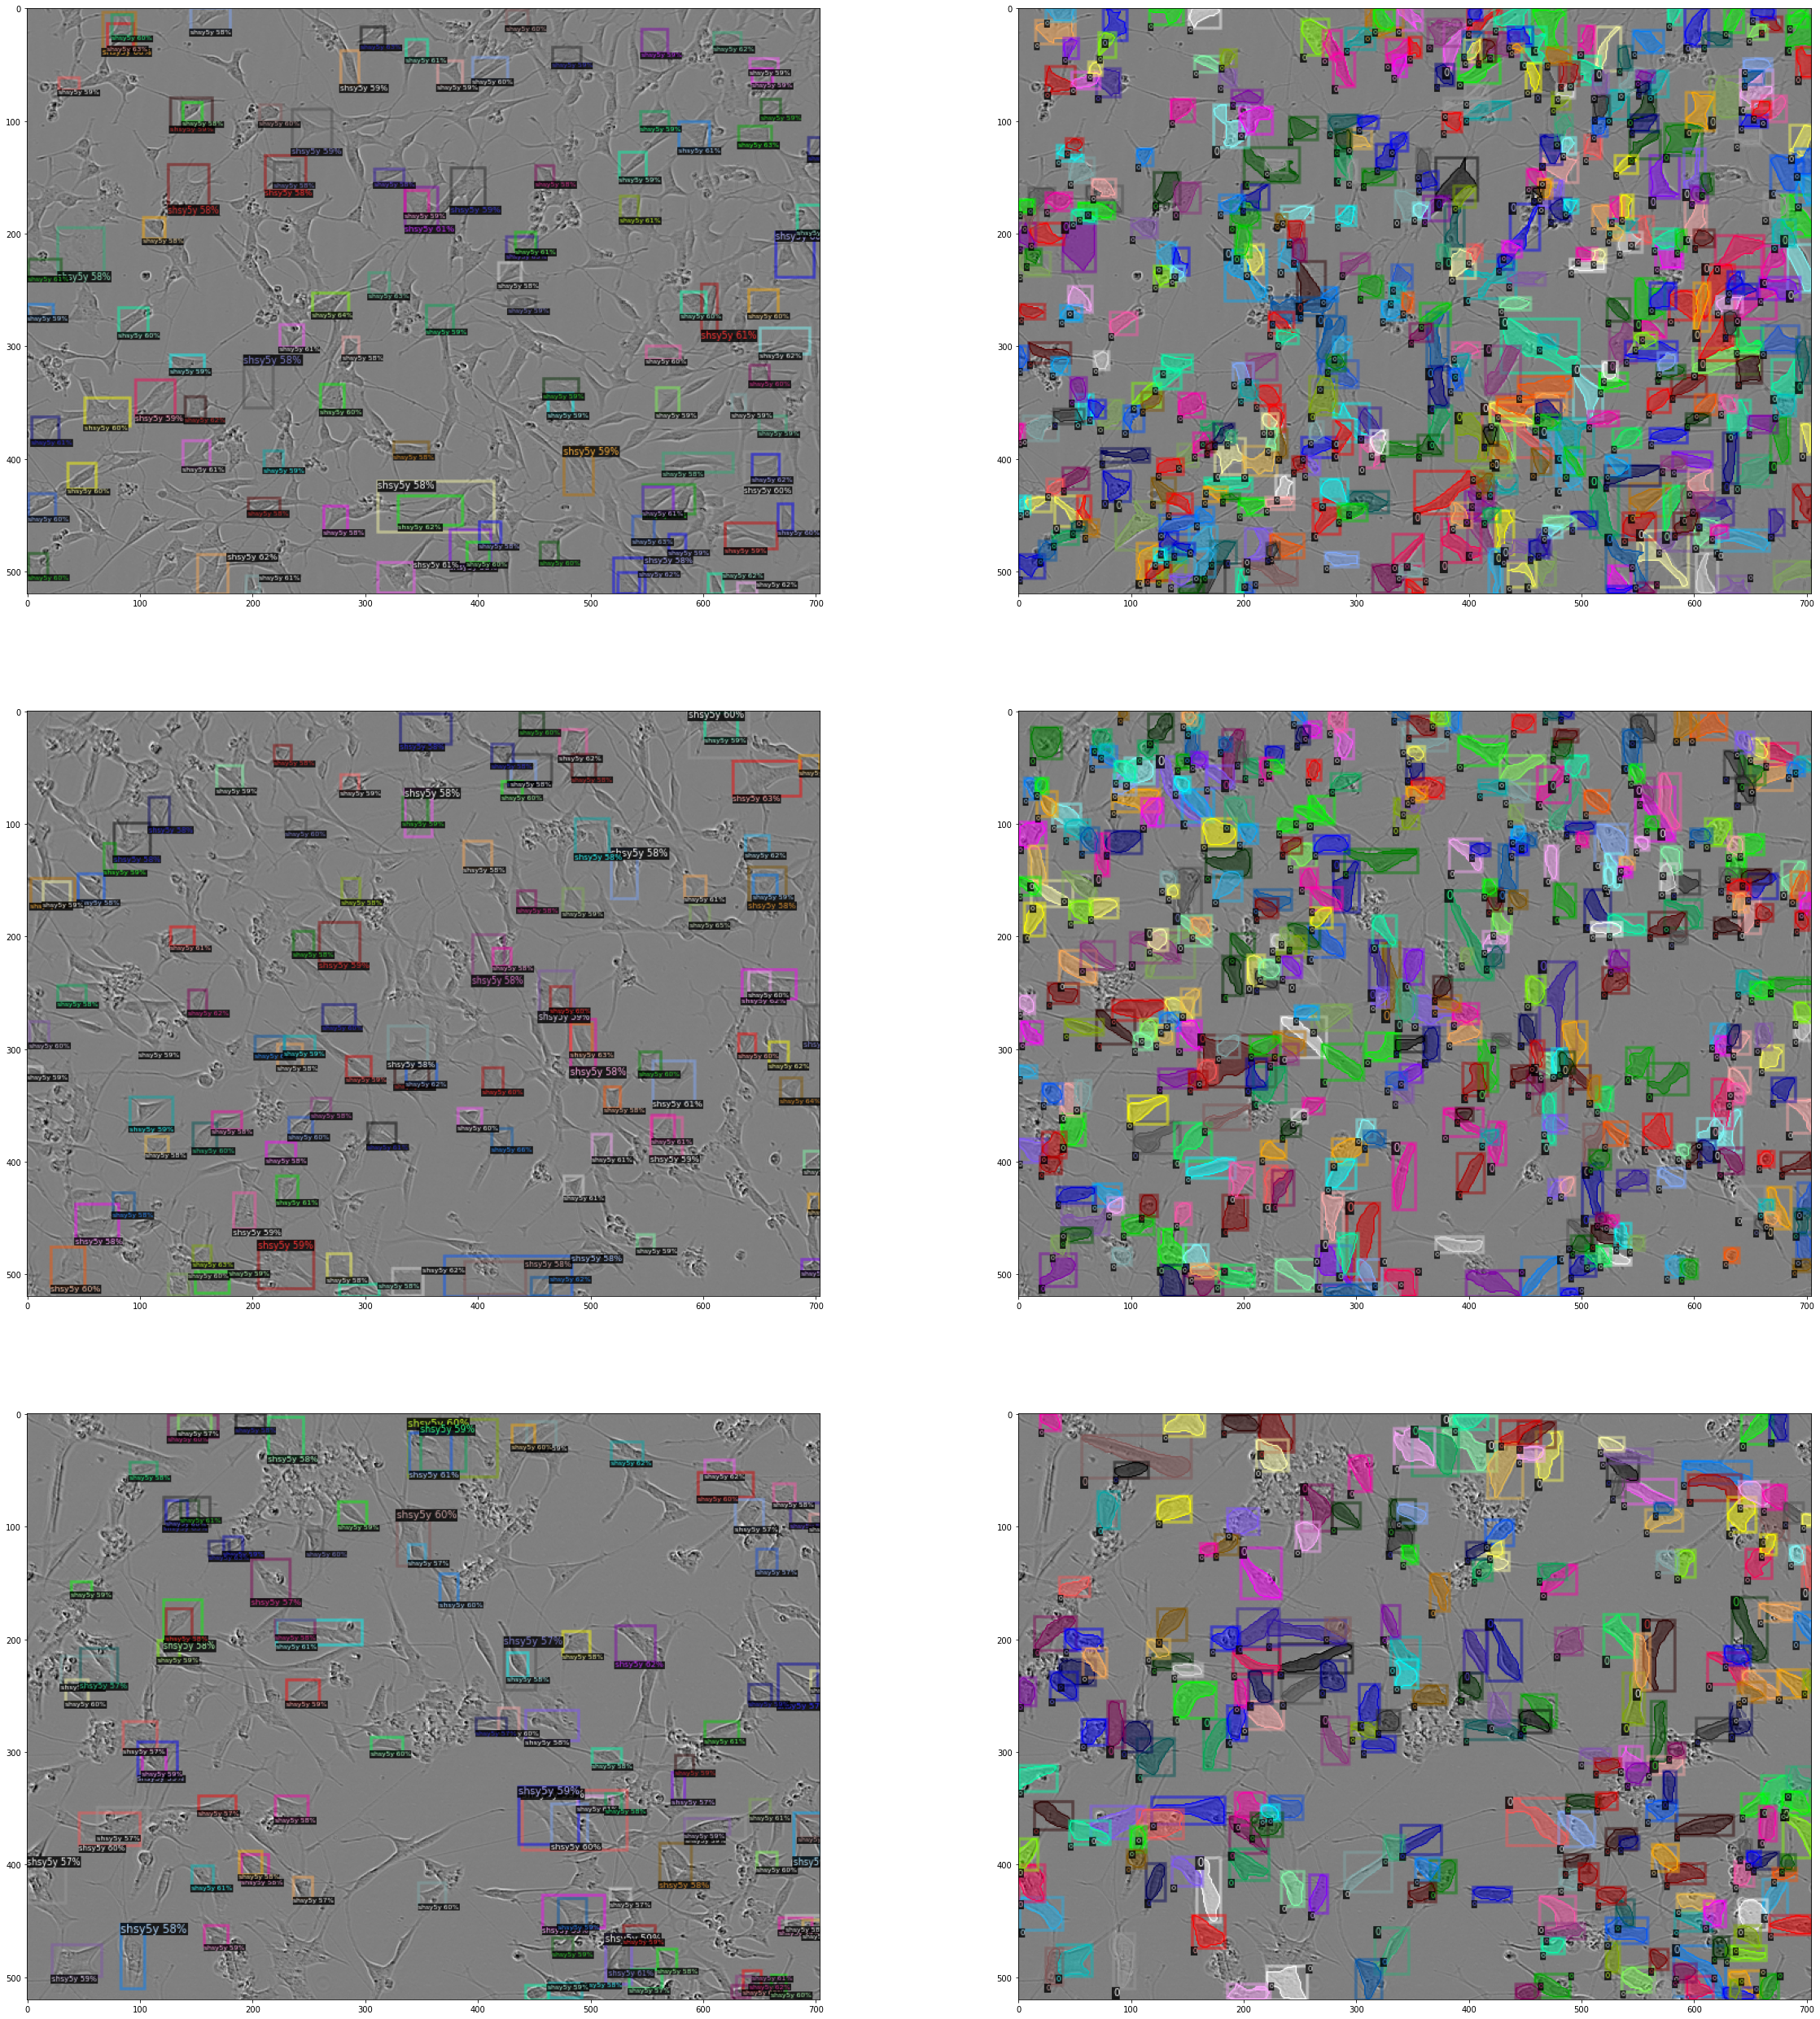

In [19]:
cfg.MODEL.WEIGHTS = os.path.join('./output', 'model_best.pth')  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
predictor = DefaultPredictor(cfg)
dataset_dicts = DatasetCatalog.get('sartorius_val')
outs = []
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata = MetadataCatalog.get('sartorius_train'), 
                    
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out_pred = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    visualizer = Visualizer(im[:, :, ::-1], metadata=MetadataCatalog.get('sartorius_train'))
    out_target = visualizer.draw_dataset_dict(d)
    outs.append(out_pred)
    outs.append(out_target)
_,axs = plt.subplots(len(outs)//2,2,figsize=(40,45))
for ax, out in zip(axs.reshape(-1), outs):
    ax.imshow(out.get_image()[:, :, ::-1])

## Inference and submission

There are two minor details we need to handle:
- The submission notebooks don't have access to the internet, in order to install detectron2 I needed to download dependecies with `pip download`, put them into a dataset and attach it to the notebook: https://www.kaggle.com/slawekbiel/detectron-05
- The masks we submit can't overlap, see [the discussion](https://www.kaggle.com/c/sartorius-cell-instance-segmentation/discussion/279790#1550666). So I'm manually clipping the output returned from the model) I'm processing the masks ordereded by score, so in the case of conflict the more confident one remaines whole and the other one gets clipped.

In [ ]:
# From https://www.kaggle.com/stainsby/fast-tested-rle
def rle_decode(mask_rle, shape=(520, 704)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)  # Needed to align to RLE direction

def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def get_masks(fn, predictor):
    im = cv2.imread(str(fn))
    pred = predictor(im)
    pred_class = torch.mode(pred['instances'].pred_classes)[0]
    take = pred['instances'].scores >= THRESHOLDS[pred_class]
    pred_masks = pred['instances'].pred_masks[take]
    pred_masks = pred_masks.cpu().numpy()
    res = []
    used = np.zeros(im.shape[:2], dtype=int) 
    for mask in pred_masks:
        mask = mask * (1-used)
        if mask.sum() >= MIN_PIXELS[pred_class]: # skip predictions with small area
            used += mask
            res.append(rle_encode(mask))
    return res

In [ ]:
ids, masks=[],[]
# test_names = (dataDir/'test').ls()
PATHGLOB = Path(dataDir/'test').glob('./*')
test_names = [fil for fil in PATHGLOB]
test_names

### Initiate a Predictor from our trained model

In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"))
cfg.INPUT.MASK_FORMAT='bitmask'
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3 
cfg.MODEL.WEIGHTS = os.path.join('./output', "model_best.pth")  
cfg.TEST.DETECTIONS_PER_IMAGE = 1000
predictor = DefaultPredictor(cfg)
THRESHOLDS = [.15, .35, .55]
MIN_PIXELS = [75, 150, 75]

### Look at the outputs on a sample test file to sanity check
I'm encoding here in the competition format and decoding back to bit mask just to make sure everything is fine

In [ ]:
encoded_masks = get_masks(test_names[0], predictor)

_, axs = plt.subplots(1,2, figsize=(40,15))
axs[1].imshow(cv2.imread(str(test_names[0])))
for enc in encoded_masks:
    dec = rle_decode(enc)
    axs[0].imshow(np.ma.masked_where(dec==0, dec))

In [ ]:
encoded_masks = get_masks(test_names[1], predictor)

_, axs = plt.subplots(1,2, figsize=(40,15))
axs[1].imshow(cv2.imread(str(test_names[1])))
for enc in encoded_masks:
    dec = rle_decode(enc)
    axs[0].imshow(np.ma.masked_where(dec==0, dec))

In [ ]:
encoded_masks = get_masks(test_names[2], predictor)

_, axs = plt.subplots(1,2, figsize=(40,15))
axs[1].imshow(cv2.imread(str(test_names[2])))
for enc in encoded_masks:
    dec = rle_decode(enc)
    axs[0].imshow(np.ma.masked_where(dec==0, dec))

### Looks good, so lets generate masks for all the files and create a submission

In [ ]:
for fn in test_names:
    encoded_masks = get_masks(fn, predictor)
    for enc in encoded_masks:
        ids.append(fn.stem)
        masks.append(enc)

In [ ]:
pd.DataFrame({'id':ids, 'predicted':masks}).to_csv('submission.csv', index=False)
pd.read_csv('submission.csv').head()